## Импорт данных и библиотек

Импорт библиотек

In [149]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from category_encoders.count import CountEncoder as ce_CountEncoder
from category_encoders.target_encoder import TargetEncoder as ce_TargetEncoder
from category_encoders.woe import WOEEncoder as ce_WOEEncoder

import scipy.stats as stats

In [68]:
!pip install category_encoders

Подключение к диску

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Импорт датасета

In [176]:
data = pd.read_csv("/content/drive/My Drive/Учеба/магистратура/2 сем/ММО/Air_Traffic_Passenger_Statistics.csv")

In [35]:
data2 = pd.read_csv("/content/drive/My Drive/Учеба/магистратура/2 сем/ММО/ryanair_reviews.csv")

## Описание датасета Air_Traffic_Passenger_Statistics

Просмотр первых 5 строк датасета

In [177]:
data.head()

,index,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July
1,1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July
2,2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July
3,3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July
4,4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July


In [178]:
data.shape

(15007, 17)

Датасет содержит информацию о статистике пассажиропотока авиакомпании. Статистика пассажиропотока может быть полезным инструментом для понимания авиационной отрасли и составления планов поездок. Данные включают количество пассажиров, выполняющую авиакомпанию, опубликованную авиакомпанию, географический регион, код типа деятельности, код ценовой категории, терминал, место посадки, а также год и месяц полета

Датасет состоит из 17 колонок:
0. index - номер колонки
1. Activity Period - период активности (Date)
2. Operating Airline - авиакомпания, выполнявшая рейс(String)
3. Operating Airline IATA Code - IATA-код авиакомпании, выполнявшей рейс (String)
4. Published Airline - авиакомпания, опубликовавшая тариф на рейс (String)
5. Published Airline - IATA-код авиакомпании, опубликовавшей тариф на рейс (String)
6. GEO Summary - краткая информация о географическом регионе (String)
7. GEO Region	T - географический регион (String)
8. Activity Type Code	- вид деятельности (String)
9. Price Category Code - ценовая категория тарифа (String)
10. Terminal - терминал рейса (String)
11. Boarding Area	- зона посадки на рейс (String)
12. Passenger Count	- количество пассажиров на рейсе (Integer)
13. Adjusted Activity Type Code	- вид деятельности, скорректированный с учетом отсутствующих данных (String)
14. Adjusted Passenger Count	- количество пассажиров на рейсе, скорректированное с учетом отсутствующих данных (Integer)
15. Year	- год активности (Integer)
16. Month	- месяц активности (Integer)

Уникальные значения некоторых колонок:

In [179]:
print(data['GEO Summary'].unique())
print(data['GEO Region'].unique())
print(data['Activity Type Code'].unique())
print(data['Price Category Code'].unique())
print(data['Terminal'].unique())
print(data['Boarding Area'].unique())
print(data['Adjusted Activity Type Code'].unique())

['Domestic' 'International']
['US' 'Canada' 'Asia' 'Europe' 'Australia / Oceania' 'Mexico'
 'Central America' 'Middle East' 'South America']
['Deplaned' 'Enplaned' 'Thru / Transit']
['Low Fare' 'Other']
['Terminal 1' 'International' 'Terminal 3' 'Other' 'Terminal 2']
['B' 'G' 'A' 'E' 'C' 'F' 'Other' 'D']
['Deplaned' 'Enplaned' 'Thru / Transit * 2']


Нулевые значения всего в 2х колонках, но для анализа мы их использовать не будем. Вырежем колонки, которые не будем использовать:

In [180]:
data=data.drop(columns=['index','Operating Airline IATA Code','Published Airline IATA Code'],axis=1)

In [181]:
data.isnull().sum().sum()

0

In [182]:
list(zip(data.columns, [i for i in data.dtypes]))

[('Activity Period', dtype('int64')),
 ('Operating Airline', dtype('O')),
 ('Published Airline', dtype('O')),
 ('GEO Summary', dtype('O')),
 ('GEO Region', dtype('O')),
 ('Activity Type Code', dtype('O')),
 ('Price Category Code', dtype('O')),
 ('Terminal', dtype('O')),
 ('Boarding Area', dtype('O')),
 ('Passenger Count', dtype('int64')),
 ('Adjusted Activity Type Code', dtype('O')),
 ('Adjusted Passenger Count', dtype('int64')),
 ('Year', dtype('int64')),
 ('Month', dtype('O'))]

## Описание датасета ryanair_reviews

Этот набор данных объединяет разнообразные мнения и рейтинги, предоставленные непосредственно самими пассажирами и охватывающие различные аспекты рейсов Ryanair с 2012 по 2024 год.

В этом наборе данных можно найти:
- Оценки пассажиров по комфорту сидений, обслуживанию бортпроводников, еде и напиткам, наземному обслуживанию и общему соотношению цены и качества.
- Подробная информация о типах путешественников, таких как туристические, деловые или семейные.
- Информация о типах самолетов, типах мест, маршрутах и датах путешествия.
- Разбивка по национальностям пассажиров и статусу подтверждения поездки.

Первые 5 строк датасета:

In [208]:
data2.head()

,Unnamed: 0,Date Published,Overall Rating,Passenger Country,Trip_verified,Comment title,Comment,Aircraft,Type Of Traveller,Seat Type,...,Destination,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity
0,0,2024-02-03,10.0,United Kingdom,Not Verified,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,Boeing 737 900,Family Leisure,Economy Class,...,Luton,February 2024,4.0,5.0,3.0,4.0,4.0,yes,NaN,NaN
1,1,2024-01-26,10.0,United Kingdom,Trip Verified,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,NaN,Couple Leisure,Economy Class,...,Alicante,January 2024,3.0,5.0,3.0,5.0,5.0,yes,NaN,NaN
2,2,2024-01-20,10.0,United Kingdom,Trip Verified,“Really impressed!”,"Really impressed! You get what you pay for, th...",Boeing 737-800,Couple Leisure,Economy Class,...,Paris Beauvais,October 2023,5.0,5.0,4.0,5.0,5.0,yes,NaN,NaN
3,3,2024-01-07,6.0,United Kingdom,Trip Verified,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,Boeing 737,Solo Leisure,Economy Class,...,Liverpool,January 2024,3.0,2.0,1.0,3.0,3.0,yes,NaN,NaN
4,4,2024-01-06,10.0,Israel,Trip Verified,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",Boeing 737-800,Solo Leisure,Economy Class,...,Manchester,January 2024,4.0,5.0,NaN,4.0,5.0,yes,NaN,NaN


In [8]:
data2.shape

(2249, 21)

Типы колонок:

In [9]:
list(zip(data2.columns, [i for i in data2.dtypes]))

[('Unnamed: 0', dtype('int64')),
 ('Date Published', dtype('O')),
 ('Overall Rating', dtype('float64')),
 ('Passenger Country', dtype('O')),
 ('Trip_verified', dtype('O')),
 ('Comment title', dtype('O')),
 ('Comment', dtype('O')),
 ('Aircraft', dtype('O')),
 ('Type Of Traveller', dtype('O')),
 ('Seat Type', dtype('O')),
 ('Origin', dtype('O')),
 ('Destination', dtype('O')),
 ('Date Flown', dtype('O')),
 ('Seat Comfort', dtype('float64')),
 ('Cabin Staff Service', dtype('float64')),
 ('Food & Beverages', dtype('float64')),
 ('Ground Service', dtype('float64')),
 ('Value For Money', dtype('float64')),
 ('Recommended', dtype('O')),
 ('Inflight Entertainment', dtype('float64')),
 ('Wifi & Connectivity', dtype('float64'))]

### Исправление "багов" датасета

Некоторые колонки с категориальными признаками имеют значения, одинаковые по смыслу, но разные по написанию. Например "NotVerified" тоже самое, что и "Not Verified". Исправим это.

In [10]:
data2['Trip_verified'] = data2['Trip_verified'].replace('Not Verified','NotVerified')
data2['Trip_verified'] = data2['Trip_verified'].replace('Unverified','NotVerified')

## Устранение пропусков

Устранять пропуски будем для датасета ryanair_reviews

### Поиск пропусков

Колонки с пропусками

In [11]:
cols_with_na = [c for c in data2.columns if data2[c].isnull().sum() > 0]
cols_with_na

['Overall Rating',
 'Trip_verified',
 'Aircraft',
 'Type Of Traveller',
 'Origin',
 'Destination',
 'Date Flown',
 'Seat Comfort',
 'Cabin Staff Service',
 'Food & Beverages',
 'Ground Service',
 'Value For Money',
 'Inflight Entertainment',
 'Wifi & Connectivity']

Числовые колонки с пропусками

In [12]:
number_cols_with_na = [c for c in data2.columns if (data2[c].isnull().sum() > 0 and data2[c].dtype == 'float64')]
number_cols_with_na

['Overall Rating',
 'Seat Comfort',
 'Cabin Staff Service',
 'Food & Beverages',
 'Ground Service',
 'Value For Money',
 'Inflight Entertainment',
 'Wifi & Connectivity']

Категориальные колонки с пропусками

In [13]:
cat_cols_with_na = [c for c in data2.columns if (data2[c].isnull().sum() > 0 and data2[c].dtype == 'O')]
cat_cols_with_na

['Trip_verified',
 'Aircraft',
 'Type Of Traveller',
 'Origin',
 'Destination',
 'Date Flown']

Колличество пропусков

In [14]:
data2.isnull().sum()

Unnamed: 0                   0
Date Published               0
Overall Rating             130
Passenger Country            0
Trip_verified              944
Comment title                0
Comment                      0
Aircraft                  1698
Type Of Traveller          614
Seat Type                    0
Origin                     615
Destination                615
Date Flown                 618
Seat Comfort               112
Cabin Staff Service        121
Food & Beverages           937
Ground Service             671
Value For Money              1
Recommended                  0
Inflight Entertainment    1918
Wifi & Connectivity       1981
dtype: int64

Доли пропусков

In [15]:
[(c, data2[c].isnull().mean()) for c in cols_with_na]

[('Overall Rating', 0.057803468208092484),
 ('Trip_verified', 0.41974210760337927),
 ('Aircraft', 0.7550022232103157),
 ('Type Of Traveller', 0.2730102267674522),
 ('Origin', 0.2734548688305914),
 ('Destination', 0.2734548688305914),
 ('Date Flown', 0.2747887950200089),
 ('Seat Comfort', 0.04979991107158737),
 ('Cabin Staff Service', 0.05380168963983993),
 ('Food & Beverages', 0.41662961316140507),
 ('Ground Service', 0.29835482436638505),
 ('Value For Money', 0.00044464206313917296),
 ('Inflight Entertainment', 0.8528234771009338),
 ('Wifi & Connectivity', 0.8808359270787016)]

### Удаление колонок с пропусками

Для примера удалим нулевые значения для 2х колонок и просмотрим изменения

In [16]:
cols2_with_na = ['Overall Rating', 'Seat Comfort']

In [17]:
data_droped = data2[cols2_with_na].dropna()

Распределение данных до и после пропусков

In [18]:
def plot_hist_diff(old_ds, new_ds, cols):
    for c in cols:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

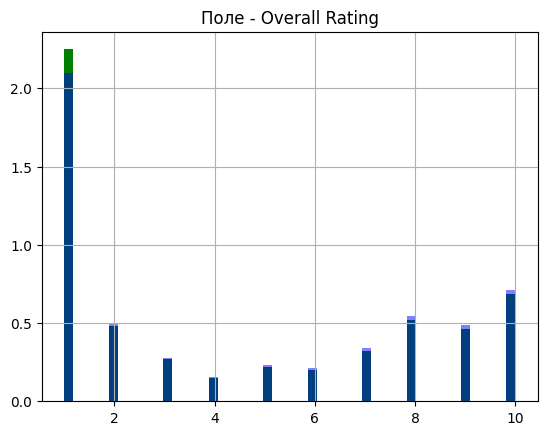

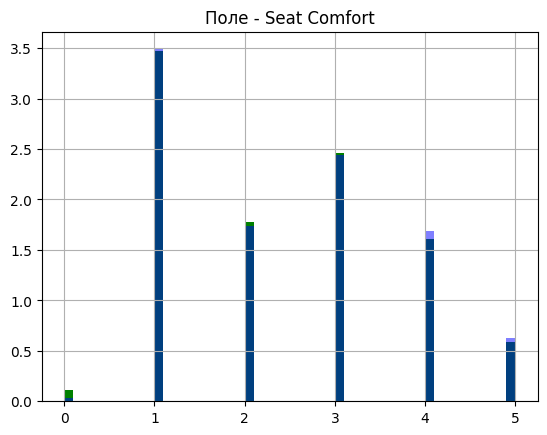

In [19]:
plot_hist_diff(data2, data_droped, cols2_with_na)

Как видим, после перераспределения, значений с рейтингом 1 стало чуть меньше. Значений остальных оценок стало чуть больше. При этом, если удалять не для 2 колонок, а для большего числа, очень много реальных значений пропадут (т.к. если есть нулевое значение в строке какой-то колонки - строка удалится, но при этом значений других колонок в этой строке просто пропадут). Отсюда следует вывод о том, что надо не удалять строки, а просто замещать пустые значения в них

### Заполнение пропусков

#### Числовые признаки

**Среднее, медиана, мода**

Для внедрения значений будем использовать класс SimpleImputer, для фильтрации пропущенных значений - MissingIndicator.

Пример заполнения пропусков средним для 1го столбца

In [20]:
col_to_fill = number_cols_with_na[0]; # 0 -> 'Overall Rating'
col_to_fill

'Overall Rating'

In [21]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

Заполним столбец средним значением и просмотрим это среднее значение

In [22]:
all_data, filled_data, missed_data = impute_column(data2, col_to_fill, 'mean')
filled_data[0]

4.380368098159509

Просмотрим распределение разных метрик для заполнения пропусков

In [23]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))

    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))

    new_df = pd.DataFrame({'Исходные данные':original_data})

    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data

    sns.kdeplot(data=new_df)

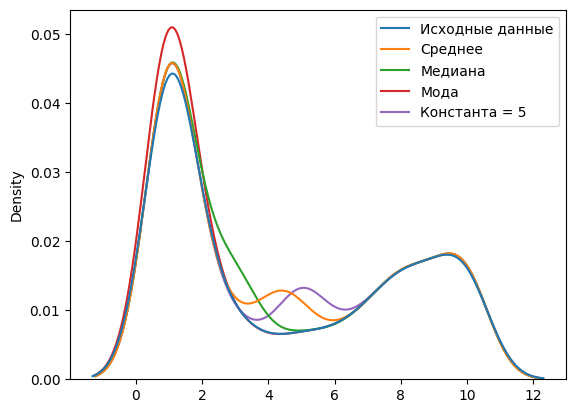

In [24]:
research_impute_numeric_column(data2, col_to_fill, 5)

На основе графика для колонки Overall Rating можно сказать следующее:
- "мода" очень сильно завышает значимость плохих оценок, поэтому ее использовать не будем;
- "среднее" и константа 5 (а это в целом тоже средняя оценка в 10-бальной шкале) вырванивают датасет, добавляя в него средние значения. Из-за этого можно упустить рейс с очень плохим рейтингом или не знать о рейсе с превосходным рейтингом, поэтому эти статистики тоже не будем использовать для заполнения пропусков;
- "медиана" для оценок работает лучше всего, поэтому на данный момент это наилуйший кандидат для заполнения пропусков.

Далее еще посмотрим другие способы заполнения пропусков.

**Заполнение "хвостом распределения".** Этот метод бы подошел, если бы хотели выделить пропущенные значения из остальных значений, но у нас пропуски в наборе случайны. При это заполнение хвостом придаст значимость выбросам, чего нам не нужно.

**Добавления флага пропусков**. Этот метод добавляет еще один столбец, где пустые значения помечаются цифрой 1. Но нам все таки нужно именно заполнить пропуски.

**Заполнение значений для нескольких признаков**. У нас оценки независимы, поэтому этот метод тоже использовать не будем.

**Заполнение случайным значением признака**. Этот метод применяется для больших выборок, поэтому его также использовать не будем.

В итоге, аналогично анализируя числовые признаки, заполним все пропуски:

In [37]:
data2_filled = data2.copy(deep=True)
data2_filled[number_cols_with_na[0]] = impute_column(data2, number_cols_with_na[0], 'median')[0]
data2_filled[number_cols_with_na[1]] = impute_column(data2, number_cols_with_na[1], 'mean')[0]
data2_filled[number_cols_with_na[2]] = impute_column(data2, number_cols_with_na[2], 'mean')[0]
data2_filled[number_cols_with_na[3]] = impute_column(data2, number_cols_with_na[3], 'median')[0]
data2_filled[number_cols_with_na[4]] = impute_column(data2, number_cols_with_na[4], 'median')[0]
data2_filled[number_cols_with_na[5]] = impute_column(data2, number_cols_with_na[5], 'median')[0]
data2_filled[number_cols_with_na[6]] = impute_column(data2, number_cols_with_na[6], 'median')[0]
data2_filled[number_cols_with_na[7]] = impute_column(data2, number_cols_with_na[7], 'median')[0]

Проверим, что пропуски были заполнены:

In [38]:
len([c for c in data2_filled.columns if (data2_filled[c].isnull().sum() > 0 and data2_filled[c].dtype == 'float64')])

0

Число числовых колонок с пропусками = 0. Пропусков в числовых данных больше нет.

#### Категориальные признаки

**Заполнение самым частым значением или константой**

Константной будем заполнять в случаях, если пропуски имеют значение, а самым частым значением в ином случае.

- Для столбца 'Trip_verified' na - имеет значение, а именно 'NotVerified'. То есть, если неизвестно, проверен ли отзыв - будем считать, что он не проверен. Заполним пропуски константой 'NotVerified';
- пропуски столбцов 'Aircraft', 'Origin', 'Destination', 'Date Flown', заполним значением 'NA' чтобы не завышать оценку самолету, пункту отправления/прибытия и дате;
- пропуски столбца 'Type Of Traveller' заполним наиболее частым значением, т.к. это не повлияет на набор, ведь уникальных типов путешественников всего 4.

In [39]:
data2_filled['Trip_verified'] = impute_column(data2, 'Trip_verified', 'constant', fill_value_param='NotVerified')[0]
data2_filled['Aircraft'] = impute_column(data2, 'Aircraft', 'constant', fill_value_param='NA')[0]
data2_filled['Type Of Traveller'] = impute_column(data2, 'Type Of Traveller', 'most_frequent')[0]
data2_filled['Origin'] = impute_column(data2, 'Origin', 'constant', fill_value_param='NA')[0]
data2_filled['Destination'] = impute_column(data2, 'Destination', 'constant', fill_value_param='NA')[0]
data2_filled['Date Flown'] = impute_column(data2, 'Date Flown', 'constant', fill_value_param='NA')[0]

Итог:

In [41]:
data2_filled.isnull().sum().sum()

0

## Кодирование категориальных признаков

Кодирование категориальных признаков будем выполнять для датасета ryanair_reviews

Категориальные признаки:

In [45]:
cat_cols = [c for c in data2_filled.columns if data2_filled[c].dtype == 'O']
cat_cols

['Date Published',
 'Passenger Country',
 'Trip_verified',
 'Comment title',
 'Comment',
 'Aircraft',
 'Type Of Traveller',
 'Seat Type',
 'Origin',
 'Destination',
 'Date Flown',
 'Recommended']

In [97]:
data2_enc = data2_filled.copy(deep=True)

### Кодирование целочисленными значениями (label encoding)

Закодируем категории мест цифрами от 0 до 3. Таким образом, получаем, что, чем больше цифра, тем круче класс полета. Это можно использовать при каких-либо анализах

In [28]:
from sklearn.preprocessing import LabelEncoder

In [89]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data2_filled['Seat Type'])

In [90]:
len(cat_enc_le)

2249

In [91]:
data2_filled['Seat Type'].unique()

array(['Economy Class', 'Premium Economy', 'Business Class',
       'First Class'], dtype=object)

Так можем посмотреть полученные цифры, которыми были закодированы категории

In [92]:
np.unique(cat_enc_le)

array([0, 1, 2, 3])

А так можно посмотреть исходные значения категорий

In [93]:
le.inverse_transform([0, 1, 2, 3])

array(['Business Class', 'Economy Class', 'First Class',
       'Premium Economy'], dtype=object)

Также далее будем использовать столбец Recommended в качестве целевого. Закодируем его 0лями и 1цами.

In [96]:
le2 = LabelEncoder()
rec_enc_le = le2.fit_transform(data2_filled['Recommended'])
np.unique(rec_enc_le)

array([0, 1])

In [95]:
le2.inverse_transform([0, 1])

array(['no', 'yes'], dtype=object)

In [98]:
data2_enc['Recommended'] = rec_enc_le

### Кодирование наборами бинарных значений (one-hot encoding)

One-hot encoding предполагает, что значение категории заменяется на отдельную колонку, которая содержит бинарные значения.

Приведем пример для столбца Type Of Traveller. В таком случае результат кодирования будет представлять собой набор строк, в которых стоит 1 для столбца, название которого и является значением исходного значения столбца 'Type Of Traveller' для этой строки.

In [209]:
pd.get_dummies(data2_filled[['Type Of Traveller']]).head()

,Type Of Traveller_Business,Type Of Traveller_Couple Leisure,Type Of Traveller_Family Leisure,Type Of Traveller_Solo Leisure
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,0,0,1


### Count (frequency) encoding

Count encoding предполагает что значение категории заменяется на количество раз, которое оно встречается в категории.

В случае frequency encoding вместо количества используется доля (процент) от количества записей.

Это очень полезные виды кодирования, которые помогут использовать значения частоты в разных вычислениях и анализах. Приведем пример для Recommended

In [210]:
ce_CountEncoder1 = ce_CountEncoder()
data_count_enc = ce_CountEncoder1.fit_transform(data2_enc[data2_enc.columns.difference(['Recommended'])])
data_count_enc

,Aircraft,Cabin Staff Service,Comment,Comment title,Date Flown,Date Published,Destination,Food & Beverages,Ground Service,Inflight Entertainment,Origin,Overall Rating,Passenger Country,Seat Comfort,Seat Type,Trip_verified,Type Of Traveller,Unnamed: 0,Value For Money,Wifi & Connectivity
0,1,5.0,1,1,1,1,13,3.0,4.0,1.0,21,10.0,1167,4.0,2229,230,374,0,4.0,1.0
1,1698,5.0,1,1,5,1,14,3.0,5.0,1.0,4,10.0,1167,3.0,2229,865,1201,1,5.0,1.0
2,322,5.0,1,1,3,1,3,4.0,5.0,1.0,35,10.0,1167,5.0,2229,865,1201,2,5.0,1.0
3,139,2.0,1,1,5,1,14,1.0,3.0,1.0,21,6.0,1167,3.0,2229,865,548,3,3.0,1.0
4,322,5.0,1,1,5,2,30,1.0,4.0,1.0,83,10.0,18,4.0,2229,865,548,4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,1698,1.0,1,699,618,4,615,1.0,1.0,1.0,615,2.0,1167,1.0,2229,946,1201,2244,1.0,1.0
2245,1698,2.0,1,699,618,4,615,0.0,1.0,1.0,615,1.0,1167,3.0,2229,946,1201,2245,1.0,1.0
2246,1698,1.0,1,699,618,4,615,1.0,1.0,1.0,615,1.0,1167,1.0,2229,946,1201,2246,1.0,1.0
2247,1698,1.0,1,699,618,4,615,1.0,1.0,1.0,615,1.0,55,1.0,2229,946,1201,2247,2.0,1.0


In [108]:
data_count_enc['Type Of Traveller'].unique()

array([ 374, 1201,  548,  126])

Таким образом получили количества встречающихся типов пассажиров

In [211]:
ce_CountEncoder2 = ce_CountEncoder(normalize=True)
data_freq_enc = ce_CountEncoder2.fit_transform(data2_enc[data2_enc.columns.difference(['Recommended'])])
data_freq_enc

,Aircraft,Cabin Staff Service,Comment,Comment title,Date Flown,Date Published,Destination,Food & Beverages,Ground Service,Inflight Entertainment,Origin,Overall Rating,Passenger Country,Seat Comfort,Seat Type,Trip_verified,Type Of Traveller,Unnamed: 0,Value For Money,Wifi & Connectivity
0,0.000445,5.0,0.000445,0.000445,0.000445,0.000445,0.005780,3.0,4.0,1.0,0.009337,10.0,0.518897,4.0,0.991107,0.102268,0.166296,0,4.0,1.0
1,0.755002,5.0,0.000445,0.000445,0.002223,0.000445,0.006225,3.0,5.0,1.0,0.001779,10.0,0.518897,3.0,0.991107,0.384615,0.534015,1,5.0,1.0
2,0.143175,5.0,0.000445,0.000445,0.001334,0.000445,0.001334,4.0,5.0,1.0,0.015562,10.0,0.518897,5.0,0.991107,0.384615,0.534015,2,5.0,1.0
3,0.061805,2.0,0.000445,0.000445,0.002223,0.000445,0.006225,1.0,3.0,1.0,0.009337,6.0,0.518897,3.0,0.991107,0.384615,0.243664,3,3.0,1.0
4,0.143175,5.0,0.000445,0.000445,0.002223,0.000889,0.013339,1.0,4.0,1.0,0.036905,10.0,0.008004,4.0,0.991107,0.384615,0.243664,4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,0.755002,1.0,0.000445,0.310805,0.274789,0.001779,0.273455,1.0,1.0,1.0,0.273455,2.0,0.518897,1.0,0.991107,0.420631,0.534015,2244,1.0,1.0
2245,0.755002,2.0,0.000445,0.310805,0.274789,0.001779,0.273455,0.0,1.0,1.0,0.273455,1.0,0.518897,3.0,0.991107,0.420631,0.534015,2245,1.0,1.0
2246,0.755002,1.0,0.000445,0.310805,0.274789,0.001779,0.273455,1.0,1.0,1.0,0.273455,1.0,0.518897,1.0,0.991107,0.420631,0.534015,2246,1.0,1.0
2247,0.755002,1.0,0.000445,0.310805,0.274789,0.001779,0.273455,1.0,1.0,1.0,0.273455,1.0,0.024455,1.0,0.991107,0.420631,0.534015,2247,2.0,1.0


In [110]:
data_freq_enc['Type Of Traveller'].unique()

array([0.16629613, 0.53401512, 0.24366385, 0.0560249 ])

Таким образом получили доли встречающихся типов пассажиров

### Target (Mean) encoding

Target encoding предполагает что значение категории заменяется на ранг, соответствующий среднему значению целевого признака для этой категории.

В случае Mean encoding в кодируемый признак подставляется усредненное значение целевого признака.

Фактически, ранг зависит от вероятности появления целевого признака, при условии, что кодируемый признак принимает определенное значение.

Кодирование признака управляется значением целевого признака, возникает монотонная зависимость между кодируемым признаком и целевым признаком.

In [212]:
ce_TargetEncoder1 = ce_TargetEncoder()
data_mean_enc = ce_TargetEncoder1.fit_transform(data2_enc[data2_enc.columns.difference(['Recommended'])], data2_enc['Recommended'])
data_mean_enc

,Aircraft,Cabin Staff Service,Comment,Comment title,Date Flown,Date Published,Destination,Food & Beverages,Ground Service,Inflight Entertainment,Origin,Overall Rating,Passenger Country,Seat Comfort,Seat Type,Trip_verified,Type Of Traveller,Unnamed: 0,Value For Money,Wifi & Connectivity
0,0.467390,5.0,0.467390,0.467390,0.467390,0.467390,0.386695,3.0,4.0,1.0,0.484167,10.0,0.413025,4.0,0.388964,0.213043,0.312834,0,4.0,1.0
1,0.295642,5.0,0.467390,0.467390,0.426452,0.467390,0.376890,3.0,5.0,1.0,0.406588,10.0,0.413025,3.0,0.388964,0.249711,0.406328,1,5.0,1.0
2,0.742236,5.0,0.467390,0.467390,0.430814,0.467390,0.430814,4.0,5.0,1.0,0.304324,10.0,0.413025,5.0,0.388964,0.249711,0.406328,2,5.0,1.0
3,0.510791,2.0,0.467390,0.467390,0.426452,0.467390,0.351580,1.0,3.0,1.0,0.484167,6.0,0.413025,3.0,0.388964,0.249711,0.399635,3,3.0,1.0
4,0.742236,5.0,0.467390,0.467390,0.426452,0.403654,0.323594,1.0,4.0,1.0,0.349468,10.0,0.313223,4.0,0.388964,0.249711,0.399635,4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,0.295642,1.0,0.337281,0.527897,0.533981,0.322597,0.534959,1.0,1.0,1.0,0.534959,2.0,0.413025,1.0,0.388964,0.529598,0.406328,2244,1.0,1.0
2245,0.295642,2.0,0.337281,0.527897,0.533981,0.322597,0.534959,0.0,1.0,1.0,0.534959,1.0,0.413025,3.0,0.388964,0.529598,0.406328,2245,1.0,1.0
2246,0.295642,1.0,0.337281,0.527897,0.533981,0.322597,0.534959,1.0,1.0,1.0,0.534959,1.0,0.413025,1.0,0.388964,0.529598,0.406328,2246,1.0,1.0
2247,0.295642,1.0,0.337281,0.527897,0.533981,0.322597,0.534959,1.0,1.0,1.0,0.534959,1.0,0.240800,1.0,0.388964,0.529598,0.406328,2247,2.0,1.0


In [121]:
data2_enc['Type Of Traveller'].unique()

array(['Family Leisure', 'Couple Leisure', 'Solo Leisure', 'Business'],
      dtype=object)

In [120]:
data_mean_enc['Type Of Traveller'].unique()

array([0.31283422, 0.40632806, 0.39963504, 0.38095255])

In [124]:
def check_mean_encoding(field):
    for s in data2_enc[field].unique():
        data_filter = data2_enc[data2_enc[field]==s]
        if data_filter.shape[0] > 0:
            prob = sum(data_filter['Recommended']) / data_filter.shape[0]
            print(s, '-' , prob)

In [125]:
check_mean_encoding('Type Of Traveller')

Family Leisure - 0.31283422459893045
Couple Leisure - 0.4063280599500416
Solo Leisure - 0.39963503649635035
Business - 0.38095238095238093


### Weight of evidence (WoE) encoding

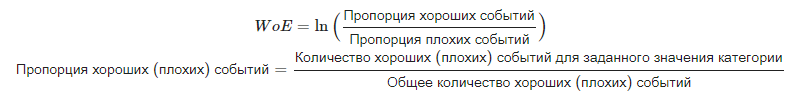

In [127]:
ce_WOEEncoder1 = ce_WOEEncoder()
data_woe_enc = ce_WOEEncoder1.fit_transform(data2_enc[data2_enc.columns.difference(['Recommended'])], data2_enc['Recommended'])

In [130]:
data2_enc['Type Of Traveller'].unique()

array(['Family Leisure', 'Couple Leisure', 'Solo Leisure', 'Business'],
      dtype=object)

In [129]:
data_woe_enc['Type Of Traveller'].unique()

array([-0.32624146,  0.07751303,  0.05056839, -0.02159405])

In [132]:
def check_woe_encoding(field):
    data_ones = data2_enc[data2_enc['Recommended'] == 1].shape[0]
    data_zeros = data2_enc[data2_enc['Recommended'] == 0].shape[0]

    for s in data2_enc[field].unique():
        data_filter = data2_enc[data2_enc[field]==s]
        if data_filter.shape[0] > 0:

            filter_data_ones = data_filter[data_filter['Recommended'] == 1].shape[0]
            filter_data_zeros = data_filter[data_filter['Recommended'] == 0].shape[0]

            good = filter_data_ones / data_ones
            bad = filter_data_zeros / data_zeros

            woe = np.log(good/bad)
            print(s, '-' , woe)

In [133]:
check_woe_encoding('Type Of Traveller')

Family Leisure - -0.33002907527778846
Couple Leisure - 0.07770706025852656
Solo Leisure - 0.04988705387080432
Business - -0.02863474096202548


### Helmert encoding

Используется для упорядоченных категориальных переменных. Cравнивает каждый уровень категориальной переменной со средним значением последующих уровней. Для нашего набора этот метод не подойдет, т.к. у нас нет упорядоченных столбцов.

## Нормализация числовых признаков

Нормализация числового признака предполагает что на основе существующего признака мы создаем новый признак, который в идеале имеет нормальное распределение.

Нормализацию числовых признаков будем выполнять для датасета Air_Traffic_Passenger_Statistics

Числовые признаки:

In [154]:
number_cols = [c for c in data.columns if data[c].dtype == 'int64']
number_cols

['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year']

In [187]:
data_number_cols = data.copy(deep=True)[number_cols]

Для начала проверим распределения наших числовых признаков

In [144]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,3))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

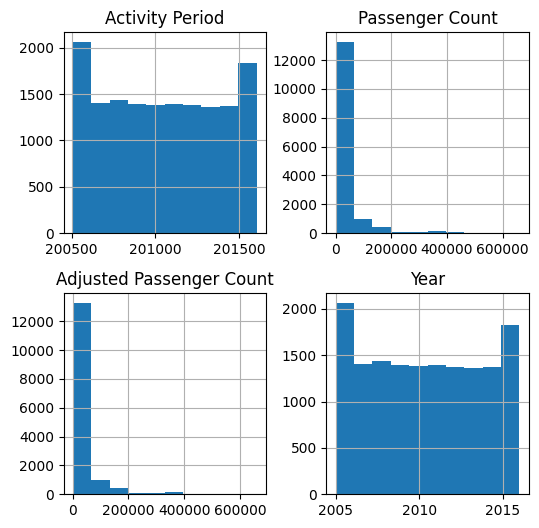

In [175]:
data_number_cols.hist(figsize=(6,6))
plt.show()

Далее будем рассматривать столбец Adjusted Passenger Count, как наиболее показательный и важный для анализа набора

In [190]:
col_to_norm = 'Adjusted Passenger Count'

Просмотрим гистограмму и Q-Q plot для одного из признаков

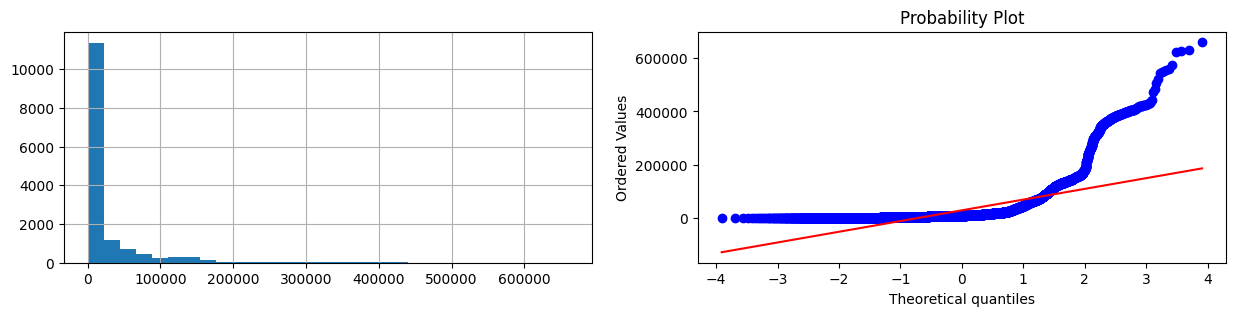

In [191]:
diagnostic_plots(data_number_cols, col_to_norm)

Как видим, распределение отличается от нормального и есть несколько способов преобразовать его в нормальное

### Логарифмическое преобразование

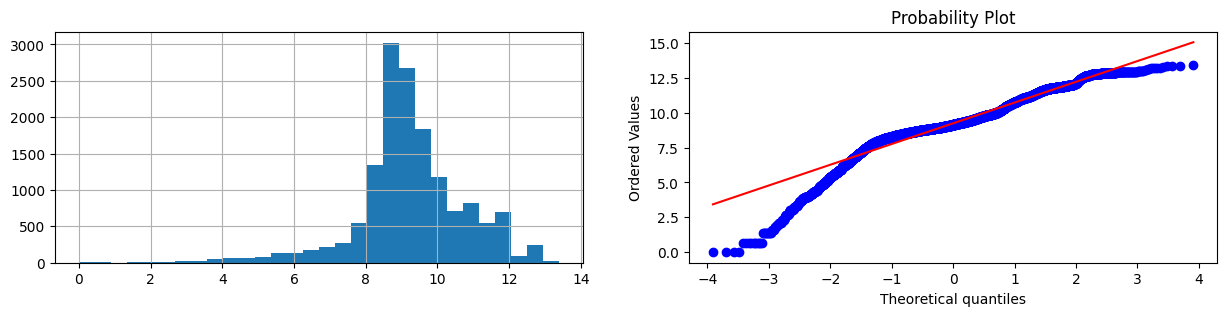

In [192]:
data_number_cols['PassengerCount_log'] = np.log(data_number_cols[col_to_norm] )
diagnostic_plots(data_number_cols, 'PassengerCount_log')

### Обратное преобразование

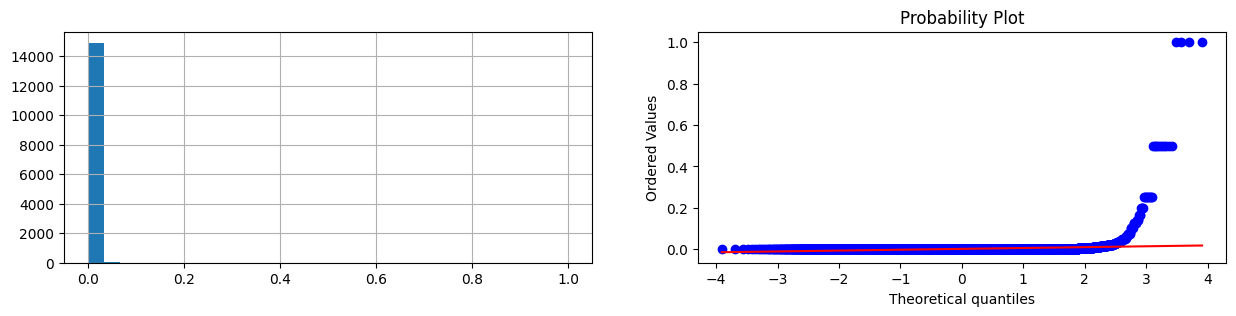

In [193]:
data_number_cols['PassengerCount_obr'] = 1 / (data_number_cols[col_to_norm])
diagnostic_plots(data_number_cols, 'PassengerCount_obr')

### Квадратный корень

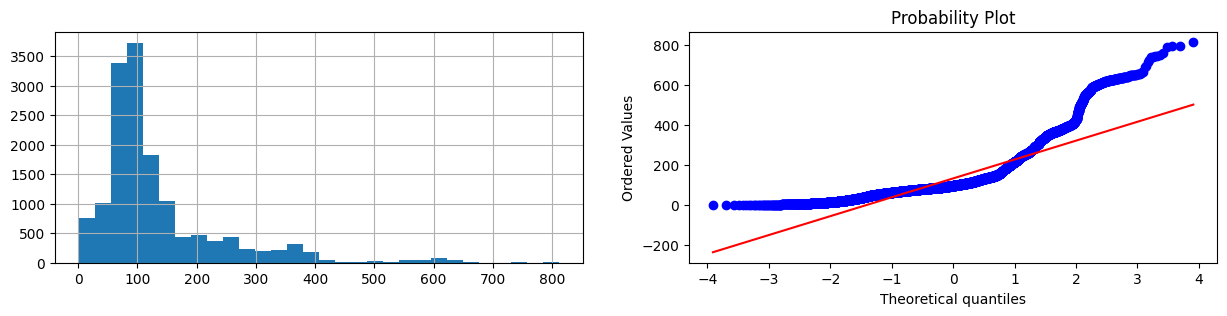

In [196]:
data_number_cols['PassengerCount_sqr'] = data_number_cols[col_to_norm]**(1/2)
diagnostic_plots(data_number_cols, 'PassengerCount_sqr')

### Возведение в степень

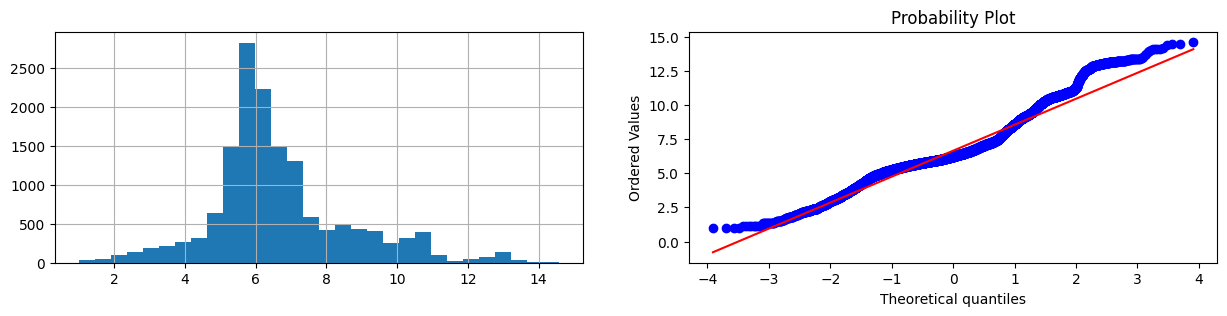

In [207]:
data_number_cols['PassengerCount_exp'] = data_number_cols[col_to_norm]**(1/5)
diagnostic_plots(data_number_cols, 'PassengerCount_exp')

### Преобразование Бокса-Кокса

Оптимальное значение λ = 0.09242759544359987


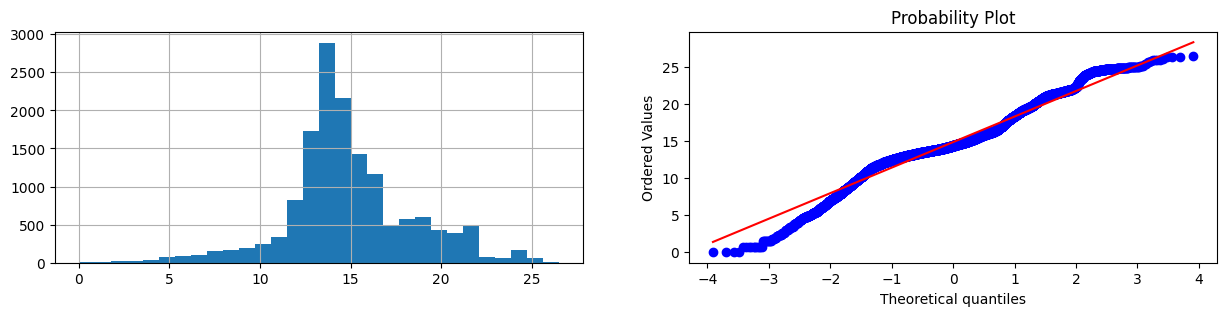

In [201]:
data_number_cols['PassengerCount_bk'], param = stats.boxcox(data_number_cols[col_to_norm])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data_number_cols, 'PassengerCount_bk')

### Преобразование Йео-Джонсона

Оптимальное значение λ = 0.09012341596054435


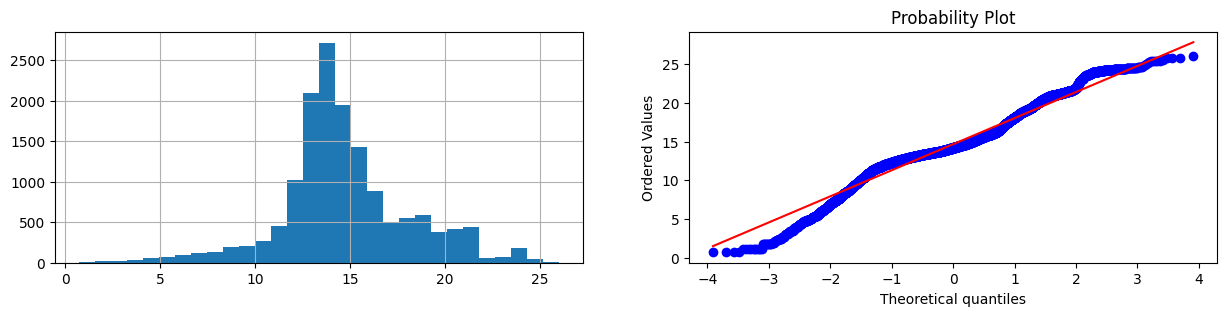

In [202]:
data_number_cols[col_to_norm] = data_number_cols[col_to_norm].astype('float')
data_number_cols['PassengerCount_yedj'], param = stats.yeojohnson(data_number_cols[col_to_norm])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data_number_cols, 'PassengerCount_yedj')

### Вывод по нормализации

Лучше всего себя показали методы Бокса-Кокса и Йео-Джонсона, а также возведение в степень (но оптимальную степень еще нужно найти перебором)